In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import seaborn as sns
from omegaconf import OmegaConf

import sys
sys.path.insert(1, '/cis/home/adesilva/ashwin/research/ProL/')

from models.transformer import * 

In [13]:
def plot_error_over_time(df, title, N=20, num_reps=100, view_range=200):
    t = df['times'][0]
    T = t + view_range

    future = df['times'][:view_range]
    mean_error = df['t_vs_avgerr'][:view_range]
    ci = df['t_vs_stderr'][:view_range] * 1.96 / np.sqrt(num_reps)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    ax = axes[0]
    future = np.arange(t, T, 1)
    xlocs = np.arange(t, T, N/2)
    for i, x in enumerate(xlocs):
        if i % 2 == 0:
            ax.add_artist(Rectangle((x, 0), N/2, 2, fc='orange', alpha=0.6))
        else:
            ax.add_artist(Rectangle((x, 0), N/2, 2, fc='b', alpha=0.6))
    ax.set_ylim([-1, 5])
    ax.set_xlim([xlocs[0], xlocs[-1]])
    ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
    ax.axis('off')

    sns.set_style("white")
    sns.set_style("ticks")

    ax = axes[1]
    ax.plot(future, mean_error, 'grey')
    ax.fill_between(future, mean_error-ci, mean_error+ci, alpha=0.2, color='grey')
    ax.set_ylabel("Error", fontsize=16)
    ax.set_xlabel("time (s > t = {})".format(t), fontsize=16)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(labelsize=13)
    ax.set_xlim([xlocs[0], xlocs[-1]])
    ax.set_ylim([0, 1])

    fig.suptitle(title)
    plt.show()

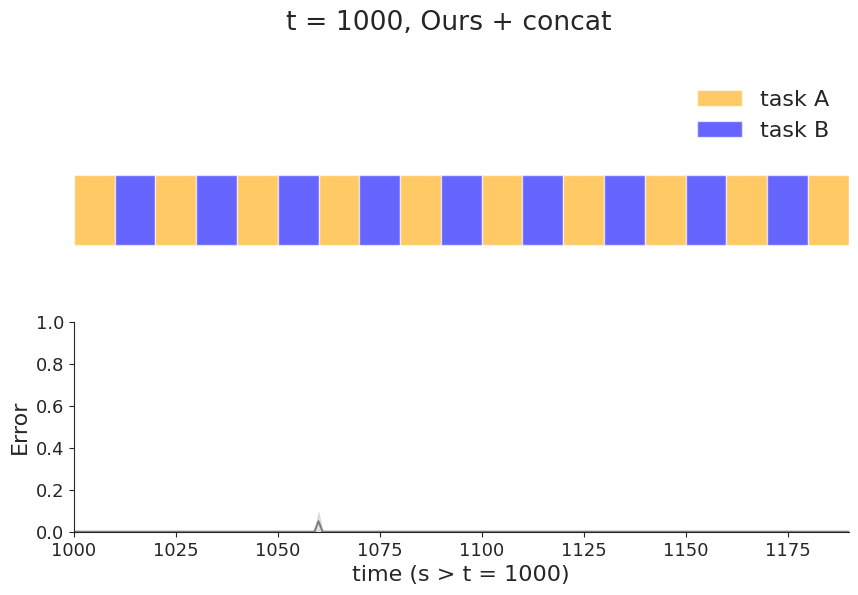

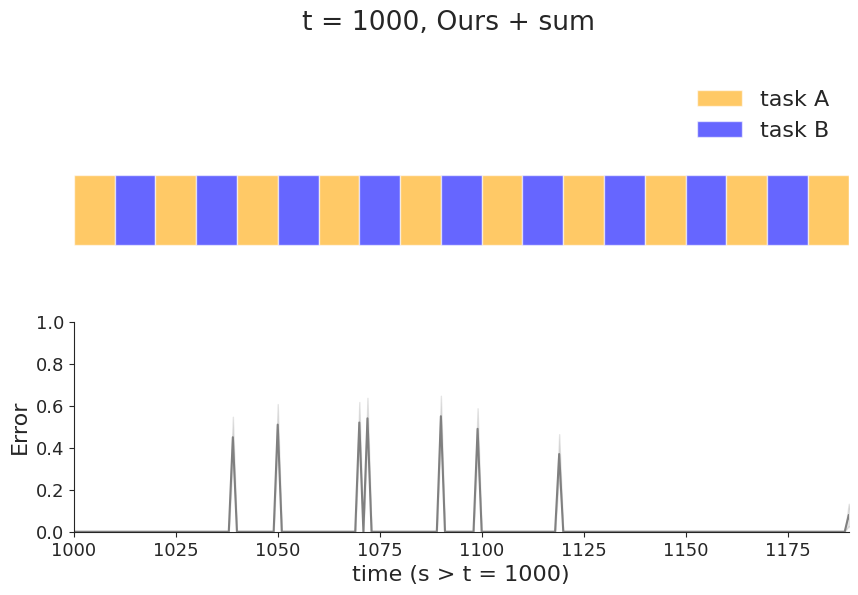

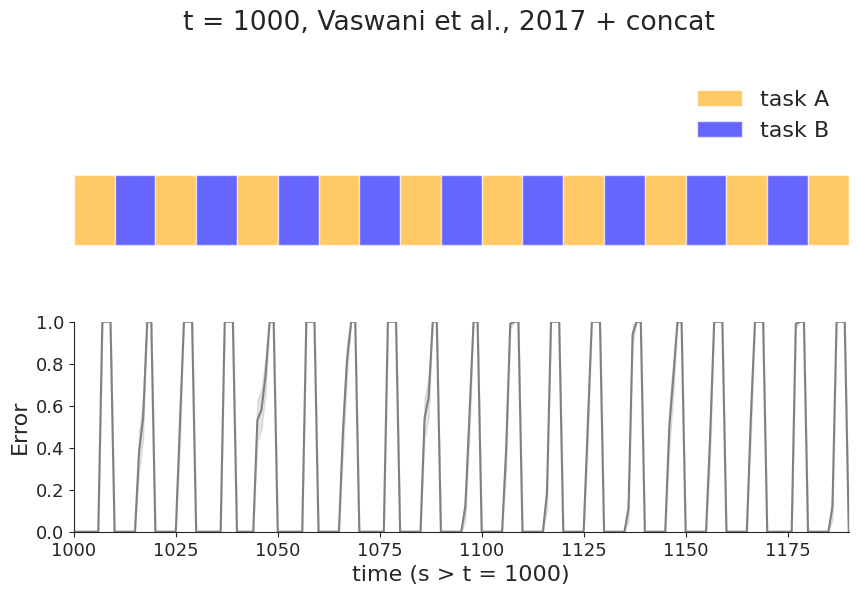

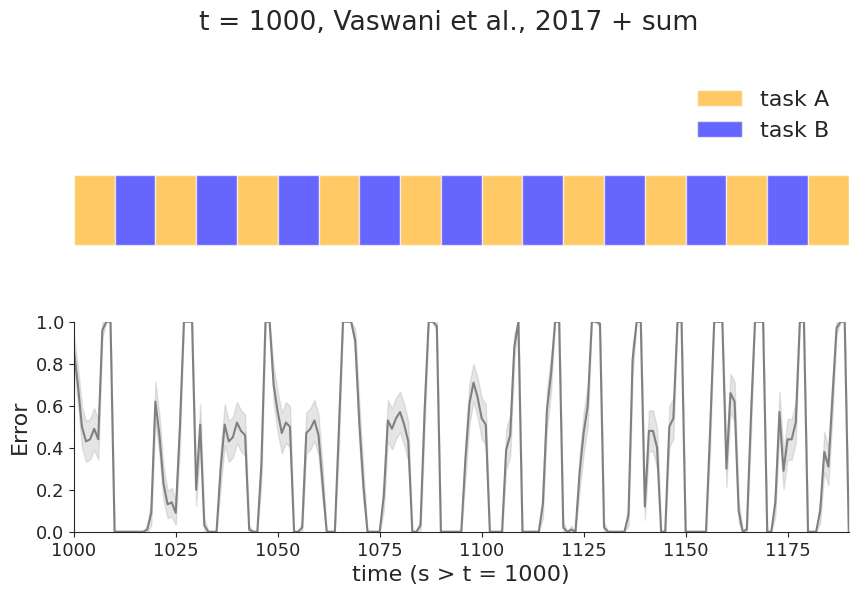

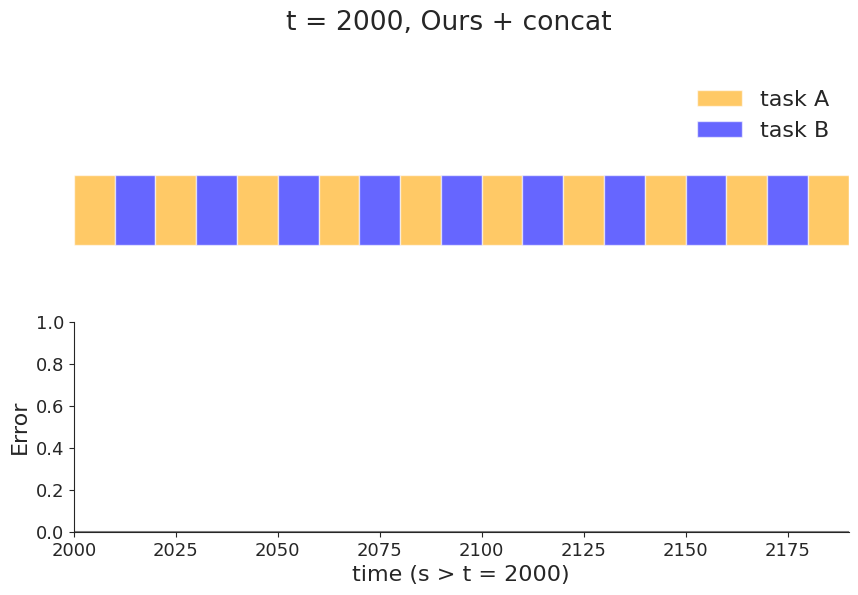

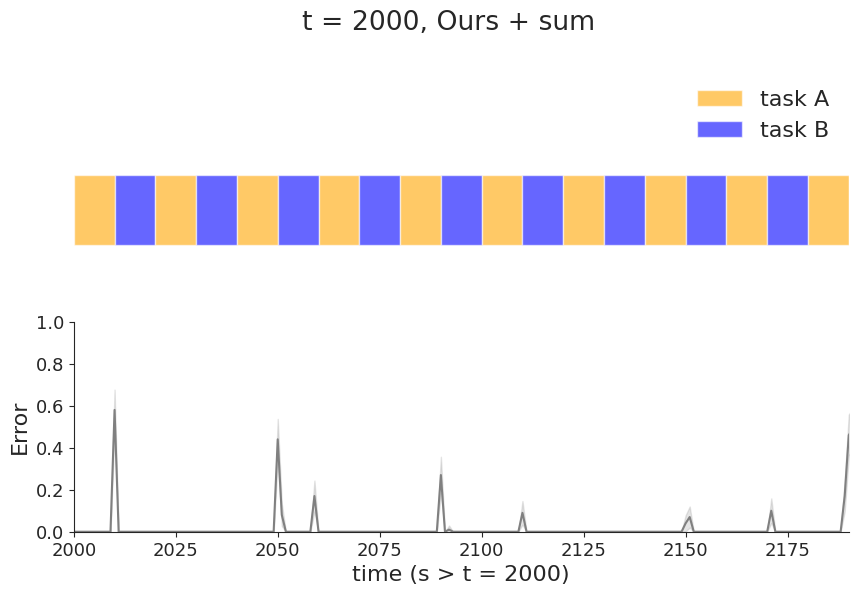

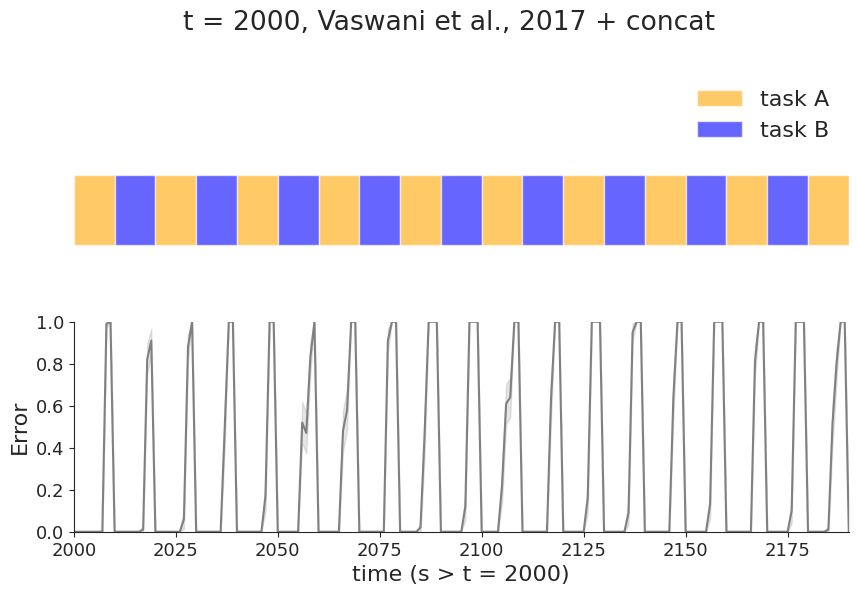

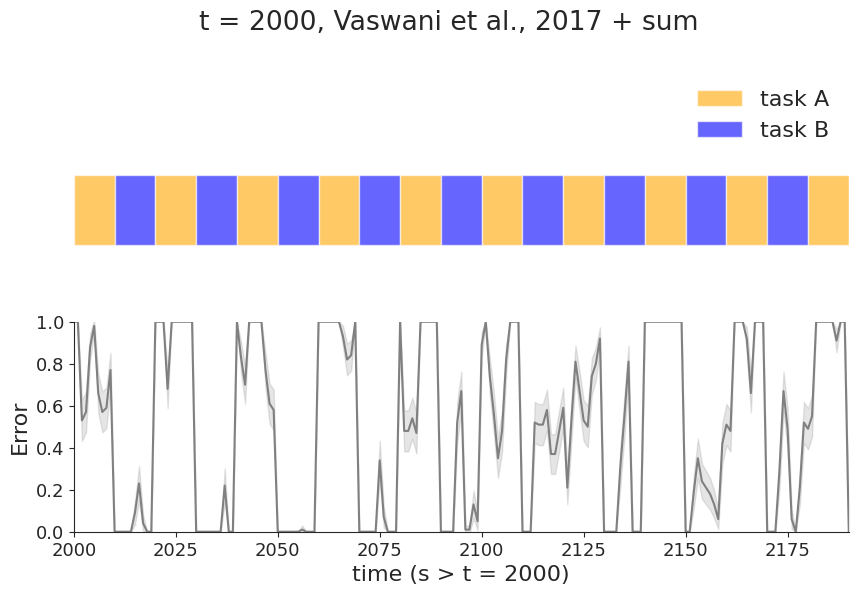

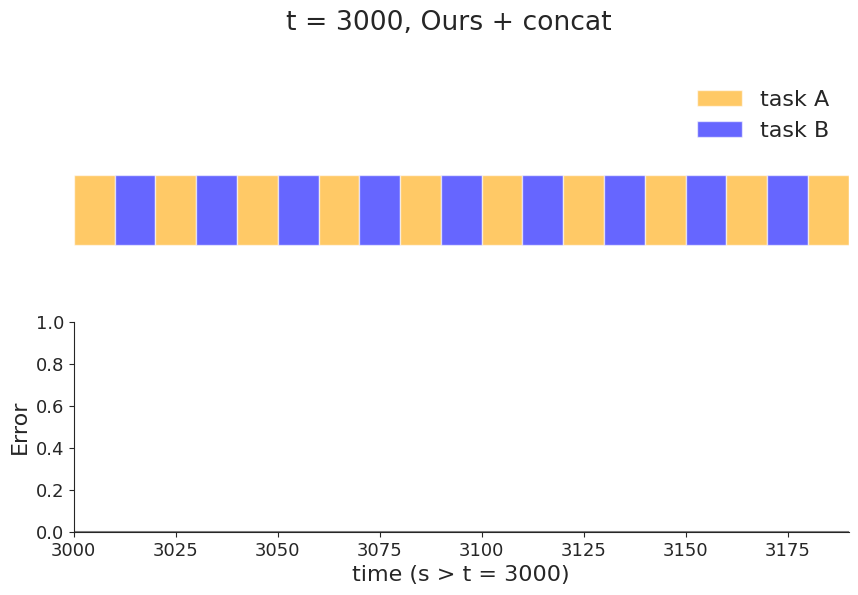

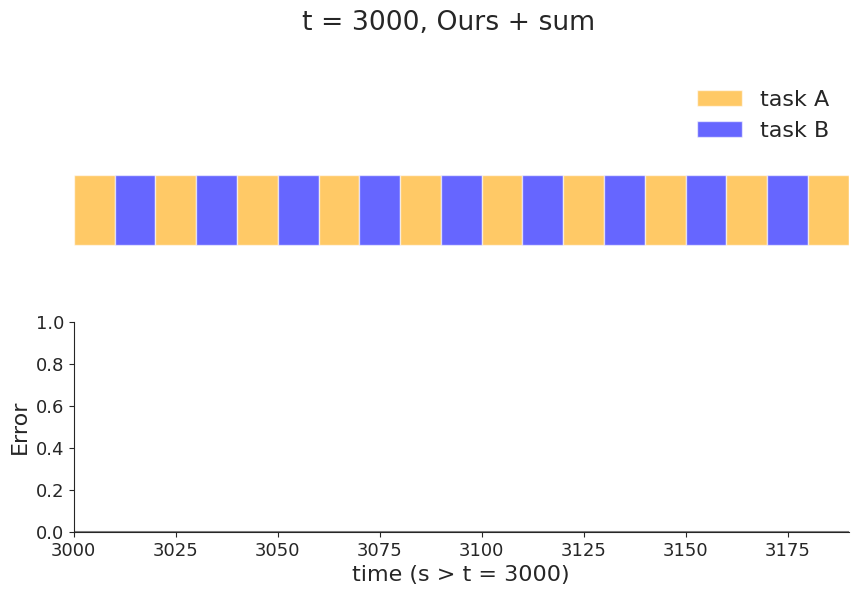

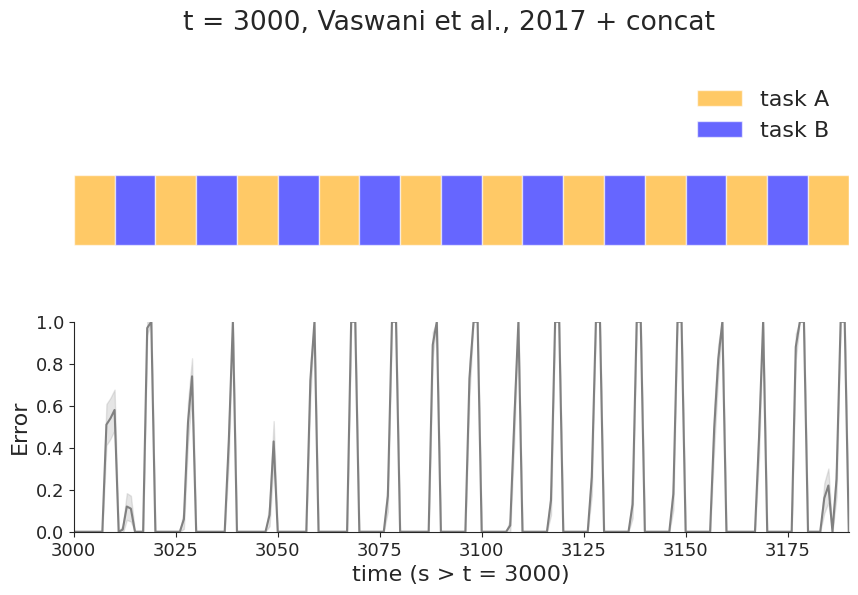

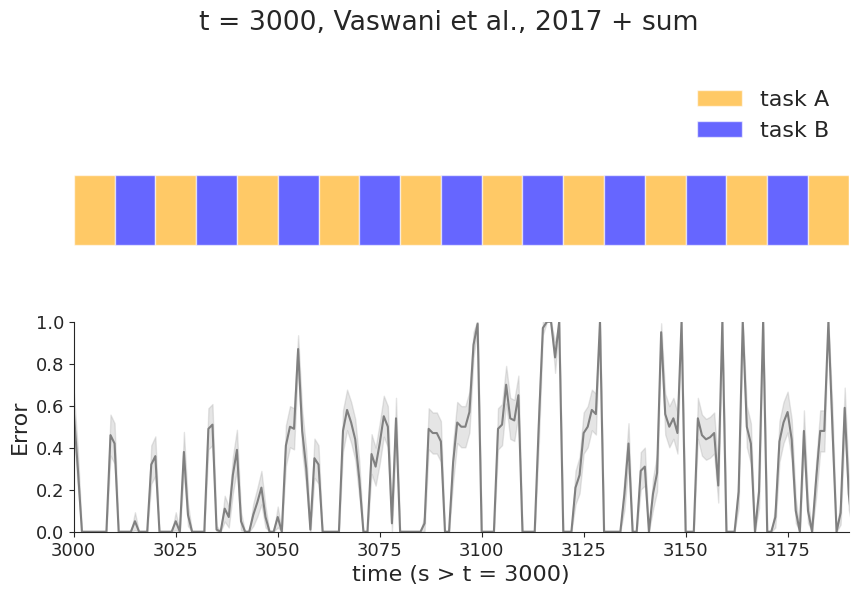

In [16]:
t_list = [1000, 2000, 3000]
posenc_list = ['fourier', 'sinusoid']
aggr_list = ['concat', 'sum']
labels = {
    'sinusoid': 'Vaswani et al., 2017', 
    'fourier': 'Ours'
    }
T = 4000

cum_err = {}
for enc in posenc_list:
    for aggr in aggr_list:
        cum_err[f"enc_{enc}_aggr_{aggr}"] = []
for t in t_list:
    for enc in posenc_list:
        for aggr in aggr_list:
            df = pd.read_csv(f"../exps/benchmark/results/t_{t}_posenc_{enc}_aggr_{aggr}.csv")
            avg_err = np.mean(df['t_vs_avgerr'])
            cum_err[f"enc_{enc}_aggr_{aggr}"].append(avg_err)
            plot_error_over_time(df, title=f"t = {t}, {labels[enc]} + {aggr}")
        

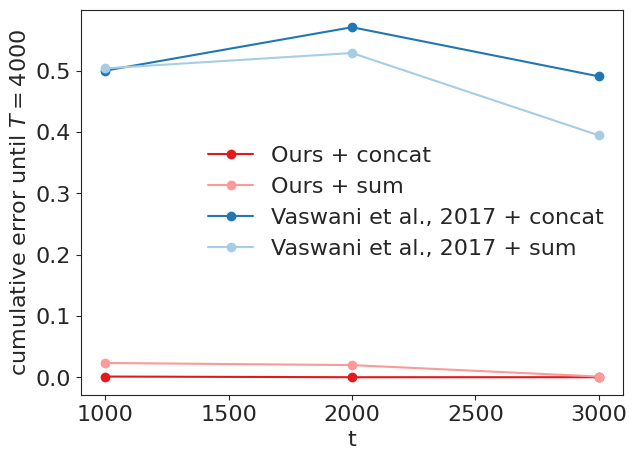

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))
labels = {
    'sinusoid': 'Vaswani et al., 2017', 
    'fourier': 'Ours'
    }
colors = [sns.color_palette("Paired")[i] for i in [5, 4, 1, 0]]
i = 0
for enc in posenc_list:
    for aggr in aggr_list:
        ax.plot(t_list, cum_err[f"enc_{enc}_aggr_{aggr}"], 'o-', label=f"{labels[enc]} + {aggr}", c=colors[i])
        i += 1
ax.set_xlabel('t')
ax.set_ylabel(r'cumulative error until $T = {}$'.format(T))
# ax.set_ylim([0, 0.5])
ax.legend(frameon=False)
plt.show()

In [43]:
cfg = OmegaConf.load('../config/conf.yaml')
cfg.net.encoder_type = 'sinusoid'
cfg.net.aggregate_type = 'sum'
model = TransformerClassifier(
            cfg,
            input_size=1,
            num_classes=2,
        )
model.load_state_dict(torch.load('../exps/benchmark/models/model_t1000_posenc_sinusoid_aggr_sum.pt'))
te_vaswani_sum = model.te.cpu().numpy().squeeze()

cfg = OmegaConf.load('../config/conf.yaml')
cfg.net.encoder_type = 'sinusoid'
cfg.net.aggregate_type = 'concat'
model = TransformerClassifier(
            cfg,
            input_size=1,
            num_classes=2,
        )
model.load_state_dict(torch.load('../exps/benchmark/models/model_t1000_posenc_sinusoid_aggr_concat.pt'))
te_vaswani_concat = model.te.cpu().numpy().squeeze()

cfg = OmegaConf.load('../config/conf.yaml')
cfg.net.encoder_type = 'fourier'
cfg.net.aggregate_type = 'sum'
model = TransformerClassifier(
            cfg,
            input_size=1,
            num_classes=2,
        )
model.load_state_dict(torch.load('../exps/benchmark/models/model_t1000_posenc_fourier_aggr_sum.pt'))
te_ours_sum = model.te.cpu().numpy().squeeze()

cfg = OmegaConf.load('../config/conf.yaml')
cfg.net.encoder_type = 'fourier'
cfg.net.aggregate_type = 'concat'
model = TransformerClassifier(
            cfg,
            input_size=1,
            num_classes=2,
        )
model.load_state_dict(torch.load('../exps/benchmark/models/model_t1000_posenc_fourier_aggr_concat.pt'))
te_ours_concat = model.te.cpu().numpy().squeeze()

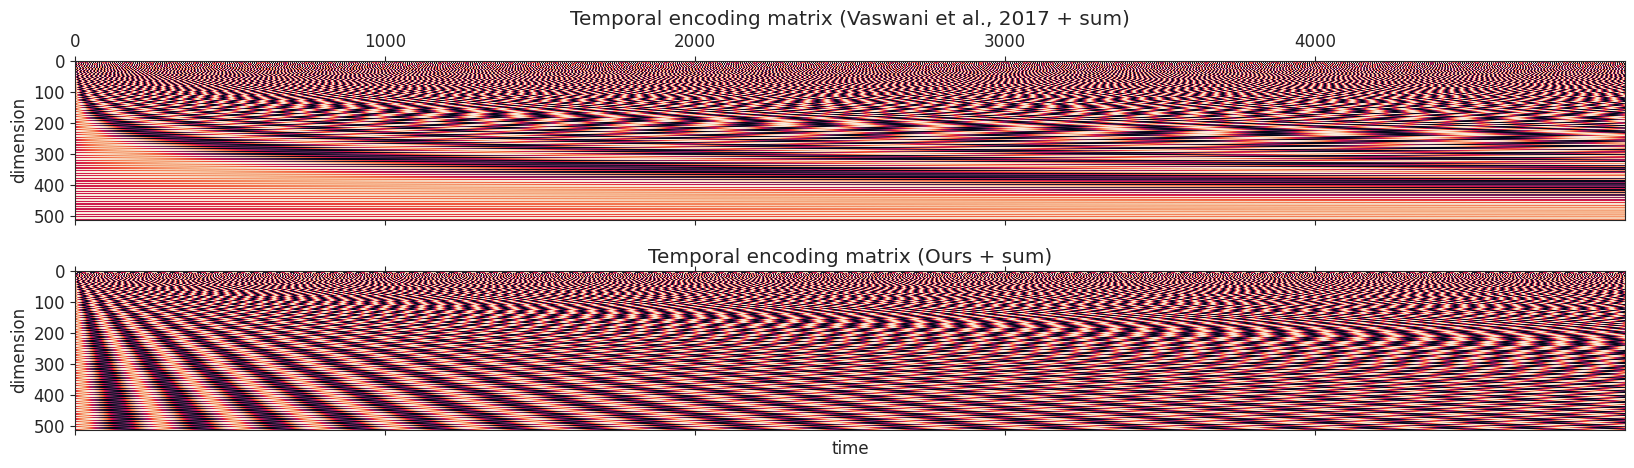

In [85]:
font = {'size':12}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'

fig, ax = plt.subplots(2, 1, figsize=(20, 5))
ax[0].matshow(te_vaswani_sum.T)
ax[1].matshow(te_ours_sum.T)
ax[0].set_title("Temporal encoding matrix (Vaswani et al., 2017 + sum)")
ax[0].set_ylabel("dimension")
ax[1].set_xticklabels([])
ax[1].set_title("Temporal encoding matrix (Ours + sum)")
ax[1].set_ylabel("dimension")
ax[1].set_xlabel("time")
plt.show()

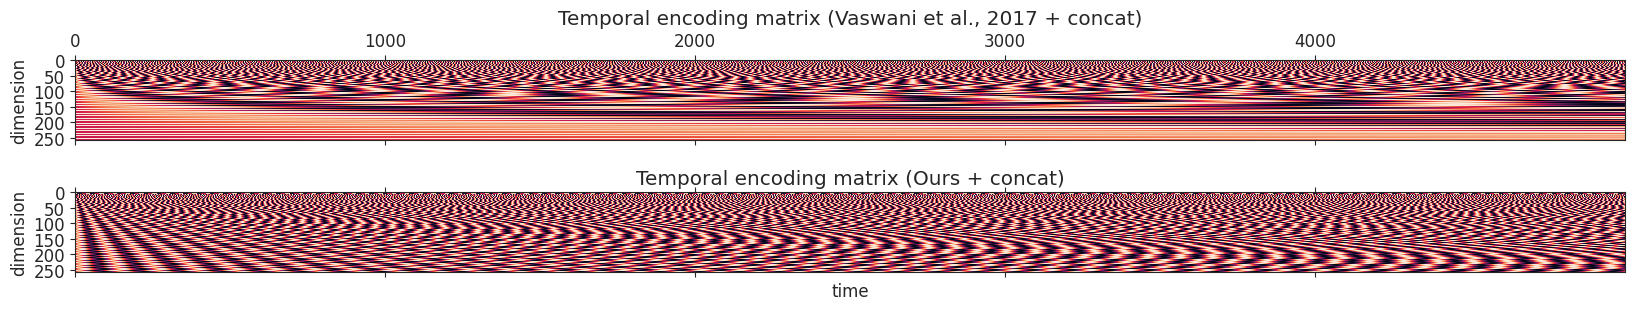

In [93]:
font = {'size':12}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'

fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].matshow(te_vaswani_concat.T)
ax[1].matshow(te_ours_concat.T)
ax[0].set_title("Temporal encoding matrix (Vaswani et al., 2017 + concat)")
ax[0].set_ylabel("dimension")
ax[1].set_xticklabels([])
ax[1].set_title("Temporal encoding matrix (Ours + concat)")
ax[1].set_ylabel("dimension")
ax[1].set_xlabel("time")
plt.subplots_adjust(wspace=0, hspace=-0.6)
plt.show()

In [10]:
cfg = OmegaConf.load('../config/conf.yaml')
cfg.encoder_type = 'sinusoid'
model = TransformerClassifier(
            cfg,
            input_size=1,
            d_model=256, 
            num_heads=4,
            ff_hidden_dim=1024,
            num_attn_blocks=1,
            num_classes=2, 
            contextlength=cfg.contextlength,
            C=100
        )
model.load_state_dict(torch.load('../exps/sinusoid-transformer-test/models/model_t1000.pt'))

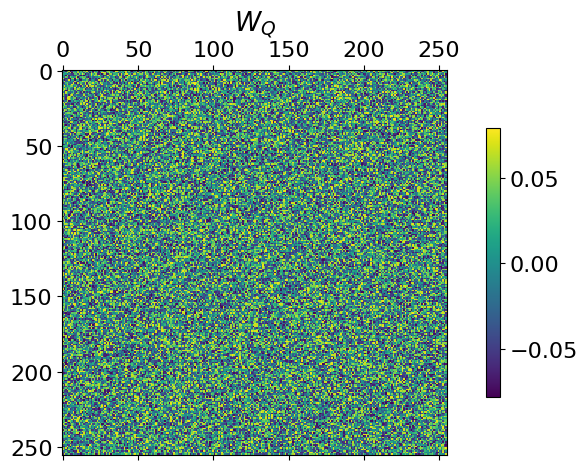

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
qkv = model.attention_blocks[0].mha.in_proj_weight
qkv = qkv.detach().cpu().numpy()
dmodel = qkv.shape[1]
cax = ax.matshow(qkv[:dmodel, :dmodel].T)
ax.set_title(fr"$W_Q$")
fig.colorbar(cax, ax = ax, shrink=0.7)
plt.show()